# Grouping speed data

Notebooks that groups edge speed data to hexagons

## Import modules

In [83]:
import os
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import math

import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Download municipality polygons

In [58]:
df = pd.read_json("../scripts/Metropolis_CVE.json")
mpos_folder = 'mpos_2020'
hex_folder = 'hex_bins_index_2020'

In [47]:
for c in df.columns.unique():
    if c == 'Guadalajara':
        mun_gdf = gpd.GeoDataFrame()
        hex_gdf = gpd.GeoDataFrame()
        for i in range(len(df.loc["mpos", c])):
            # Extracts specific municipality code
            m = df.loc["mpos", c][i]
            # Downloads municipality polygon according to code
            query = f"SELECT * FROM marco.{mpos_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
            mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
            query = f"SELECT * FROM processed.{hex_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
            hex_gdf = hex_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))

<AxesSubplot:>

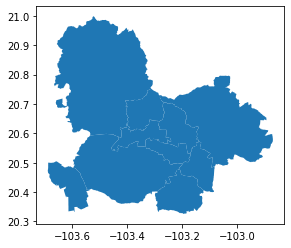

In [48]:
mun_gdf.plot()

In [49]:
print(hex_gdf.shape)
hex_gdf.head(2)

(2969, 19)


,idx_accessibility,idx_hospitales,idx_supermercado,idx_farmacias,node_count,wAcc,wHsp,wSpm,wFrm,idx_accessibility_wavg,idx_hospitales_wavg,idx_supermercado_wavg,idx_farmacias_wavg,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados
0,0.000157,0.000473,5.887650e-24,2.189688e-23,5,0.000787,0.002364,2.943825e-23,1.094844e-22,4.657651e-09,1.398694e-08,1.742094e-28,6.479058e-28,"POLYGON ((-103.54324 20.40862, -103.54269 20.4...",8849aa2611fffff,14002,9041.266800,9983.789800,9250.494800
1,0.000343,0.001031,1.124020e-21,4.180368e-21,12,0.004118,0.012368,1.348825e-20,5.016442e-20,2.437182e-08,7.318864e-08,7.982061e-26,2.968625e-25,"POLYGON ((-103.54722 20.40036, -103.54269 20.4...",8849aa261bfffff,14002,8371.216417,9313.739417,8580.444417


<AxesSubplot:>

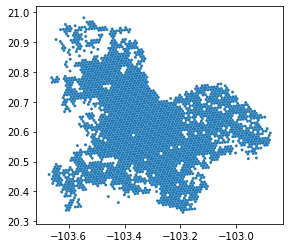

In [50]:
hex_gdf.plot()

## Download edges and nodes

In [51]:
G,nodes,edges = aup.graph_from_hippo(mun_gdf, 'osmnx', 
                                     edges_folder='edges_elevation', nodes_folder='nodes_elevation')

In [52]:
print(nodes.shape)
nodes.head(2)

(173964, 5)


,x,y,street_count,elevation,geometry
osmid,,,,,
28751344,-103.306309,20.711533,3.0,1548.0,POINT (-103.30631 20.71153)
28753224,-103.316645,20.700650,3.0,1530.0,POINT (-103.31665 20.70065)


<AxesSubplot:>

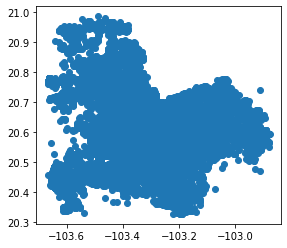

In [53]:
nodes.plot()

In [54]:
print(edges.shape)
edges.head(2)

(419221, 17)


,,,osmid,oneway,name,highway,length,geometry,grade,grade_abs,lanes,maxspeed,bridge,ref,junction,service,tunnel,access,width
u,v,key,,,,,,,,,,,,,,,,,
6817784410,6318805186,0,674712924,False,None,unclassified,1839.553,"LINESTRING (-103.48960 20.58844, -103.48922 20...",-0.083,0.083,None,None,None,None,None,None,None,None,None
6319101952,6319101960,0,674745155,False,None,residential,273.091,"LINESTRING (-103.47863 20.59270, -103.47868 20...",-0.051,0.051,None,None,None,None,None,None,None,None,None


<AxesSubplot:>

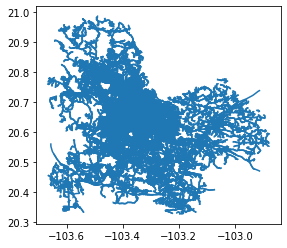

In [55]:
edges.plot()

In [56]:
edges = aup.walk_speed(edges)
edges.head(2)

,,,osmid,oneway,name,highway,length,geometry,grade,grade_abs,lanes,maxspeed,bridge,ref,junction,service,tunnel,access,width,walkspeed
u,v,key,,,,,,,,,,,,,,,,,,
6817784410,6318805186,0,674712924,False,None,unclassified,1839.553,"LINESTRING (-103.48960 20.58844, -103.48922 20...",-0.083,0.083,None,None,None,None,None,None,None,None,None,2.991558
6319101952,6319101960,0,674745155,False,None,residential,273.091,"LINESTRING (-103.47863 20.59270, -103.47868 20...",-0.051,0.051,None,None,None,None,None,None,None,None,None,3.346096


## Grouping data

Intersect hexagon and edge data

In [13]:
hex_gdf = hex_gdf.set_crs("EPSG:4326")
res_intersection = edges.overlay(hex_gdf, how='intersection')

In [14]:
print(res_intersection.shape)
res_intersection.head(5)

(462707, 36)


,osmid,oneway,name,highway,length,grade,grade_abs,lanes,maxspeed,bridge,...,idx_accessibility_wavg,idx_hospitales_wavg,idx_supermercado_wavg,idx_farmacias_wavg,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados,geometry
0,674712924,False,None,unclassified,1839.553,-0.083,0.083,None,None,None,...,3.390163e-07,0.000001,1.055893e-18,5.586566e-12,8849ab5849fffff,14097,3178.0725,5839.0345,5644.1495,"LINESTRING (-103.48424 20.58580, -103.48423 20..."
1,674745155,False,None,residential,262.501,-0.080,0.080,None,None,None,...,3.390163e-07,0.000001,1.055893e-18,5.586566e-12,8849ab5849fffff,14097,3178.0725,5839.0345,5644.1495,"LINESTRING (-103.47649 20.58912, -103.47651 20..."
2,153888349,False,Paseo de la Frescura,tertiary,943.672,-0.090,0.090,None,None,None,...,3.390163e-07,0.000001,1.055893e-18,5.586566e-12,8849ab5849fffff,14097,3178.0725,5839.0345,5644.1495,"LINESTRING (-103.47635 20.58906, -103.47635 20..."
3,674745155,False,None,residential,262.501,0.080,0.080,None,None,None,...,3.390163e-07,0.000001,1.055893e-18,5.586566e-12,8849ab5849fffff,14097,3178.0725,5839.0345,5644.1495,"LINESTRING (-103.47653 20.58866, -103.47653 20..."
4,"[949284099, 949284100]",False,None,residential,32.807,0.000,0.000,None,None,None,...,3.390163e-07,0.000001,1.055893e-18,5.586566e-12,8849ab5849fffff,14097,3178.0725,5839.0345,5644.1495,"LINESTRING (-103.47536 20.58785, -103.47527 20..."


Calculate length for every edge within each hexagon for weighted average

In [15]:
res_intersection = res_intersection.to_crs("EPSG:6372")

res_intersection['length'] = res_intersection.geometry.length


In [16]:
res_intersection.groupby('hex_id_8').sum()

,oneway,length,grade,grade_abs,walkspeed,idx_accessibility,idx_hospitales,idx_supermercado,idx_farmacias,node_count,...,wHsp,wSpm,wFrm,idx_accessibility_wavg,idx_hospitales_wavg,idx_supermercado_wavg,idx_farmacias_wavg,dist_farmacia,dist_hospitales,dist_supermercados
hex_id_8,,,,,,,,,,,,,,,,,,,,,
88498c800dfffff,0,312.978265,0.000000e+00,0.024,7.670958,2.674616e-08,8.031879e-08,6.443788e-26,6.443788e-26,2,...,8.031879e-08,6.443788e-26,6.443788e-26,1.582781e-13,4.753097e-13,3.813299e-31,3.813299e-31,38799.338000,37003.558000,38556.294000
88498c8045fffff,0,5425.834331,0.000000e+00,0.708,78.764621,1.468626e-06,4.410289e-06,7.088167e-25,7.088167e-25,88,...,1.764116e-05,2.835267e-24,2.835267e-24,3.476409e-11,1.043967e-10,1.677851e-29,1.677851e-29,395220.490500,375466.910500,392547.006500
88498c8047fffff,0,917.666456,0.000000e+00,0.250,52.638283,5.060809e-07,1.519762e-06,4.510652e-25,4.510652e-25,70,...,7.598812e-06,2.255326e-24,2.255326e-24,1.497440e-11,4.496817e-11,1.334655e-29,1.334655e-29,258941.617200,246371.157200,257240.309200
88498c8049fffff,0,5827.969415,3.469447e-18,0.724,94.473123,5.170575e-06,1.552725e-05,8.376925e-25,8.376925e-25,260,...,1.552725e-04,8.376925e-24,8.376925e-24,3.059838e-10,9.188702e-10,4.957288e-29,4.957288e-29,437296.914600,418836.041000,439021.609000
88498c804bfffff,0,3522.554164,0.000000e+00,0.472,34.017277,8.030848e-07,2.411666e-06,3.221894e-25,3.221894e-25,40,...,9.646664e-06,1.288758e-24,1.288758e-24,1.900995e-11,5.708693e-11,7.626597e-30,7.626597e-30,175720.095000,169768.155000,177531.835000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8849abcb23fffff,55,8907.227034,5.000000e-02,0.166,249.765362,2.603457e-02,7.818188e-02,5.427774e-23,4.748479e-20,1386,...,1.720001e+00,1.194110e-21,1.044665e-18,3.389476e-06,1.017861e-05,7.066494e-27,6.182111e-24,574481.733000,576184.371000,642710.355000
8849abcb2bfffff,28,5802.561397,0.000000e+00,0.006,167.916439,7.846525e-03,2.356314e-02,1.353196e-24,2.349237e-23,798,...,4.476996e-01,2.571071e-23,4.463550e-22,8.822477e-07,2.649392e-06,1.521506e-28,2.641435e-27,415374.363158,416509.455158,460860.111158
8849abcb31fffff,2,3109.544188,-1.000000e-03,0.003,55.958122,3.745208e-04,1.124687e-03,4.510652e-25,4.510652e-25,70,...,5.623435e-03,2.255326e-24,2.255326e-24,1.108168e-08,3.327831e-08,1.334655e-29,1.334655e-29,162037.047200,162415.411200,177198.963200


edge speed by hexagon weighted average

In [64]:
dict_hex = {}

for h in list(res_intersection.hex_id_8.unique()):
    sum_len = res_intersection.loc[res_intersection.hex_id_8 == h]['length'].sum()
    wWalkSpeed = []
    
    for idx, row in res_intersection.loc[res_intersection.hex_id_8 == h].iterrows():
        wWalkSpeed.append((row['length']*row['walkspeed'])/sum_len)
        
    dict_hex[h] = [sum(wWalkSpeed)]

In [77]:
df_walkspeed = pd.DataFrame.from_dict(dict_hex, orient='index', columns=['walkspeed']).reset_index()
df_walkspeed.rename(columns={'index':'hex_id_8'},inplace=True)

In [79]:
gdf_mrg = hex_gdf.merge(df_walkspeed, on='hex_id_8')
gdf_mrg.head(2)

,idx_accessibility,idx_hospitales,idx_supermercado,idx_farmacias,node_count,wAcc,wHsp,wSpm,wFrm,idx_accessibility_wavg,idx_hospitales_wavg,idx_supermercado_wavg,idx_farmacias_wavg,geometry,hex_id_8,CVEGEO,dist_farmacia,dist_hospitales,dist_supermercados,walkspeed
0,0.000157,0.000473,5.887650e-24,2.189688e-23,5,0.000787,0.002364,2.943825e-23,1.094844e-22,4.657651e-09,1.398694e-08,1.742094e-28,6.479058e-28,"POLYGON ((-103.54324 20.40862, -103.54269 20.4...",8849aa2611fffff,14002,9041.266800,9983.789800,9250.494800,3.716005
1,0.000343,0.001031,1.124020e-21,4.180368e-21,12,0.004118,0.012368,1.348825e-20,5.016442e-20,2.437182e-08,7.318864e-08,7.982061e-26,2.968625e-25,"POLYGON ((-103.54722 20.40036, -103.54269 20.4...",8849aa261bfffff,14002,8371.216417,9313.739417,8580.444417,3.657693


Plot average speed for every hexagon with an edge

<AxesSubplot:>

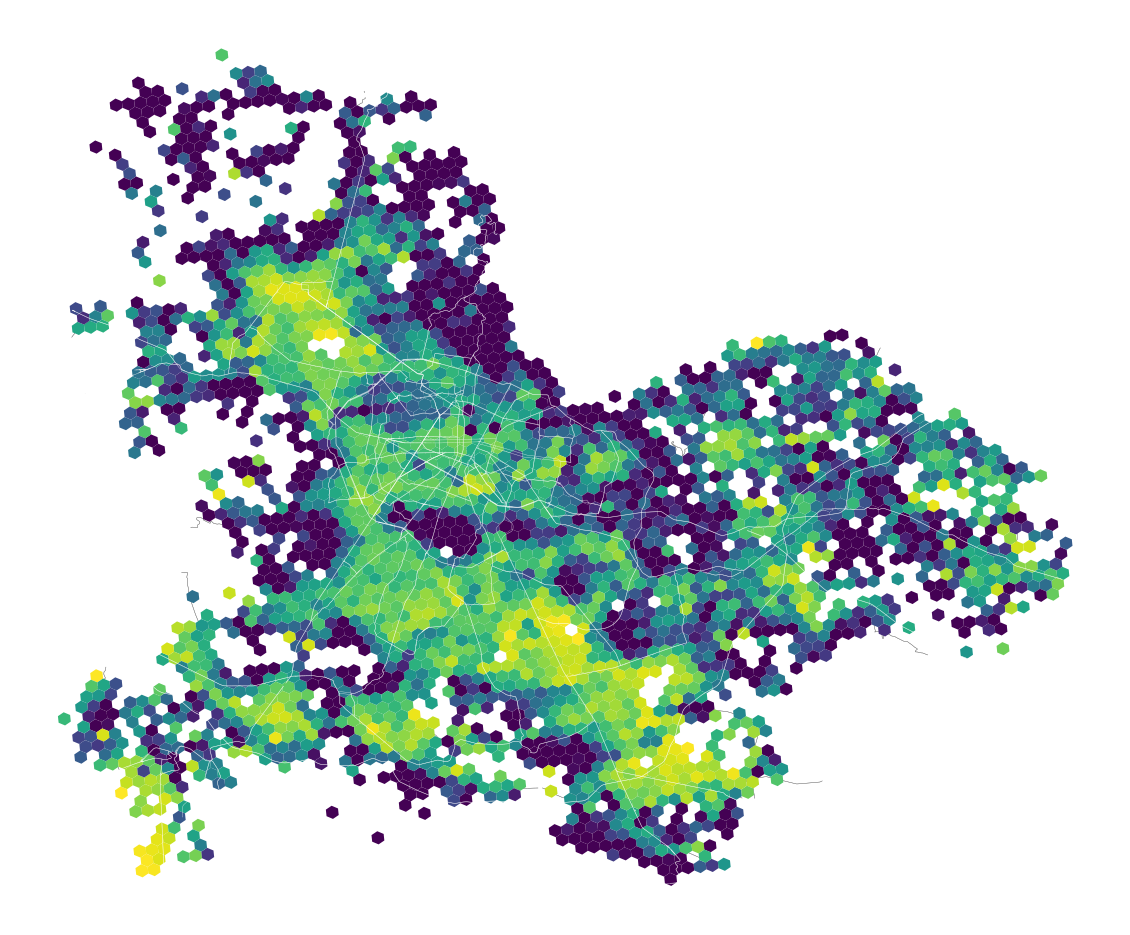

In [111]:
fig = plt.figure(figsize=(20,20))

ax = fig.gca()
ax.set_axis_off()

edges[edges['highway'].isin(['primary','primary_link','secondary','secondary_link','trunk','motorway'])].plot(color='white', ax=ax, zorder=2, alpha=0.7, linewidth=0.45)
edges[edges['highway'].isin(['tertiary','tertiary_link'])].plot(color='grey', ax=ax, zorder=-1, linewidth=0.4)

gdf_mrg.plot('walkspeed', vmax=4, vmin=3.5, ax=ax)

## Walkspeed and population

Download hexagons with population data

In [90]:
hex_pop_folder = 'hex_bins_pop_2020'

for c in df.columns.unique():
    if c == 'Guadalajara':
        hex_pop = gpd.GeoDataFrame()
        for i in range(len(df.loc["mpos", c])):
            # Extracts specific municipality code
            m = df.loc["mpos", c][i]
            # Downloads municipality polygon according to code
            query = f"SELECT * FROM processed.{hex_pop_folder} WHERE \"CVEGEO\" LIKE \'{m}\'"
            hex_pop = hex_pop.append(aup.gdf_from_query(query, geometry_col='geometry'))

In [98]:
hex_pop.head(2)

,geometry,hex_id_8,CVEGEO,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic
0,"POLYGON ((-103.59563 20.44547, -103.60016 20.4...",8849abc9adfffff,14002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"POLYGON ((-103.58905 20.38316, -103.59357 20.3...",8849abc909fffff,14002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Merge population and speed data

In [94]:
gdf_mrg_pop = gdf_mrg[['hex_id_8','walkspeed']].merge(hex_pop, on='hex_id_8')

Plot speed for every hexagon with population data

<AxesSubplot:>

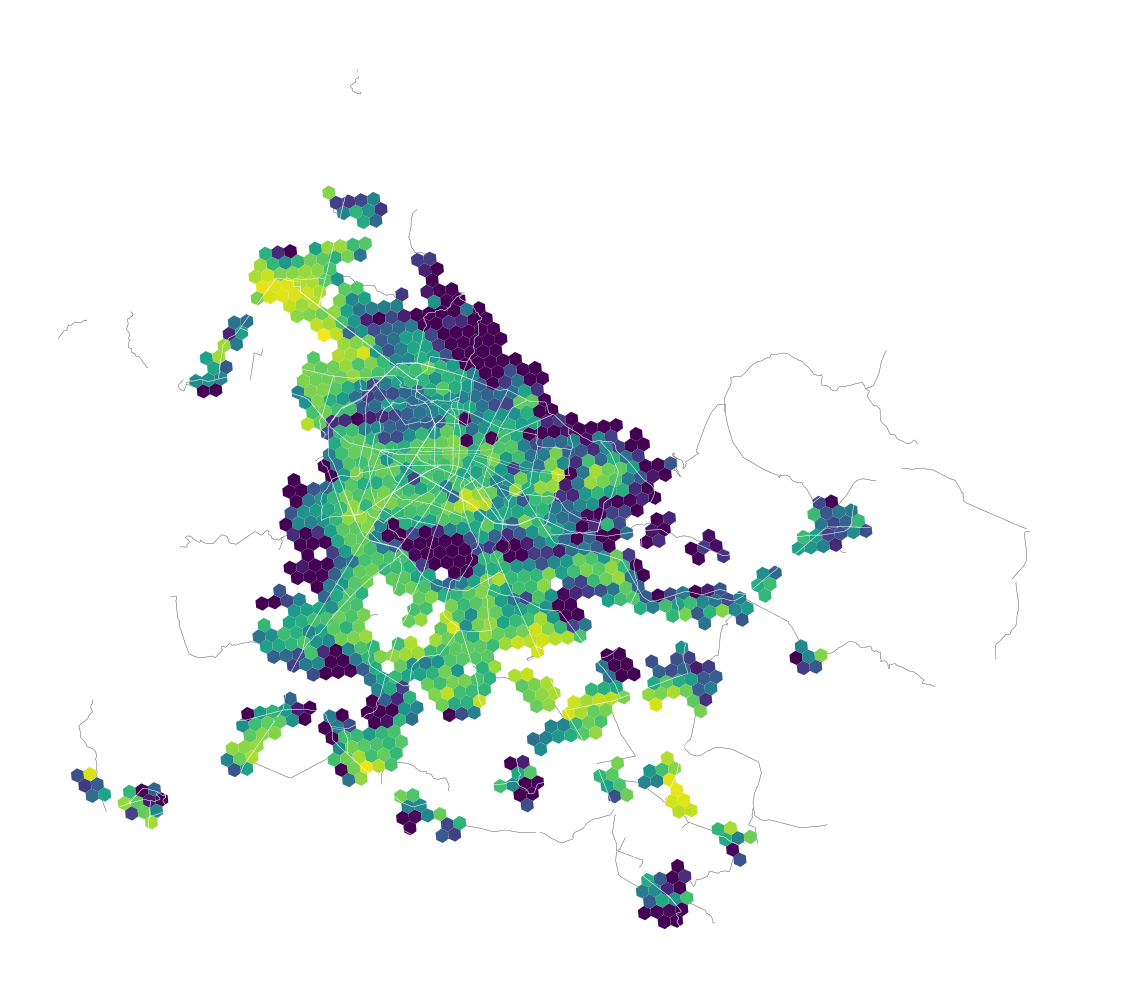

In [112]:
fig = plt.figure(figsize=(20,20))

ax = fig.gca()
ax.set_axis_off()

gdf_mrg_pop = gdf_mrg_pop.loc[gdf_mrg_pop.pobtot>0]

gdf_mrg_pop = gpd.GeoDataFrame(gdf_mrg_pop, geometry='geometry')

edges[edges['highway'].isin(['primary','primary_link','secondary','secondary_link','trunk','motorway'])].plot(color='white', ax=ax, zorder=2, alpha=0.7, linewidth=0.45)
edges[edges['highway'].isin(['tertiary','tertiary_link'])].plot(color='grey', ax=ax, zorder=-1, linewidth=0.4)

gdf_mrg_pop.plot('walkspeed', vmax=4, vmin=3.5, ax=ax)

In [96]:
gdf_mrg_pop

,hex_id_8,walkspeed,geometry,CVEGEO,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,...,vph_telef,vph_cel,vph_inter,vph_stvp,vph_spmvpi,vph_cvj,vph_sinrtv,vph_sintlc,vph_sincint,vph_sintic
0,8849aa2611fffff,3.716005,"POLYGON ((-103.54324 20.40862, -103.54269 20.4...",14002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8849aa261bfffff,3.657693,"POLYGON ((-103.54722 20.40036, -103.54269 20.4...",14002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8849aa2689fffff,3.536374,"POLYGON ((-103.56573 20.43790, -103.56518 20.4...",14002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,8849aa268bfffff,3.882848,"POLYGON ((-103.57135 20.44522, -103.57080 20.4...",14002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8849aa2691fffff,3.667673,"POLYGON ((-103.57807 20.46293, -103.58260 20.4...",14002,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964,8849aa6ed7fffff,3.791523,"POLYGON ((-102.93792 20.55569, -102.93845 20.5...",14124,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2965,8849aa6edbfffff,3.693552,"POLYGON ((-102.95154 20.54655, -102.95206 20.5...",14124,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2966,8849aa6eddfffff,3.653321,"POLYGON ((-102.94596 20.53921, -102.94090 20.5...",14124,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2967,8849aa6ee7fffff,3.174958,"POLYGON ((-102.90406 20.55624, -102.90354 20.5...",14124,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
